# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">1-Packges and libraries</center>

In [112]:
#Musts
import pandas as pd
import numpy as np
from datetime import datetime
import math
import itertools

# plotting and graphs
import plotly.express as px
import matplotlib.pyplot as plt

# analysis
import scipy.stats

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

#Models(forcasting)
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.arima.model import ARIMA



# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">2-Data</center>

In [2]:
df_orginal = pd.read_csv(f"data/{'btc'}_daily.csv", parse_dates = ['time'])
df = df_orginal.copy(deep=True)

df.rename(columns={
    'time':'date',
    'open':'price',
} ,inplace=True)

df.index = pd.DatetimeIndex(df.date).to_period('D')
df.drop(columns=['date','close','market_cap','volume'],inplace=True)
df.head()


,price
date,
2013-04-29,134.444
2013-04-30,144.000
2013-05-01,139.000
2013-05-02,116.380
2013-05-03,106.250


In [3]:
adful_result = adfuller(df.price)
print('ADF Statistic: %f' % adful_result[0])
print('p-value: %f' % adful_result[1])

ADF Statistic: -1.612029
p-value: 0.476911


In [4]:
# the price obviously not stationary
df["returns"] = df.price.pct_change(1).mul(100)
df.dropna(inplace=True)

In [136]:
df_train = df.iloc[:-447] 
df_test  = df.iloc[-447:] 

# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">3-Analysis</center>

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">a- QQ-plot</center>

/tmp/ipykernel_2240259/430023291.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_qq.show()


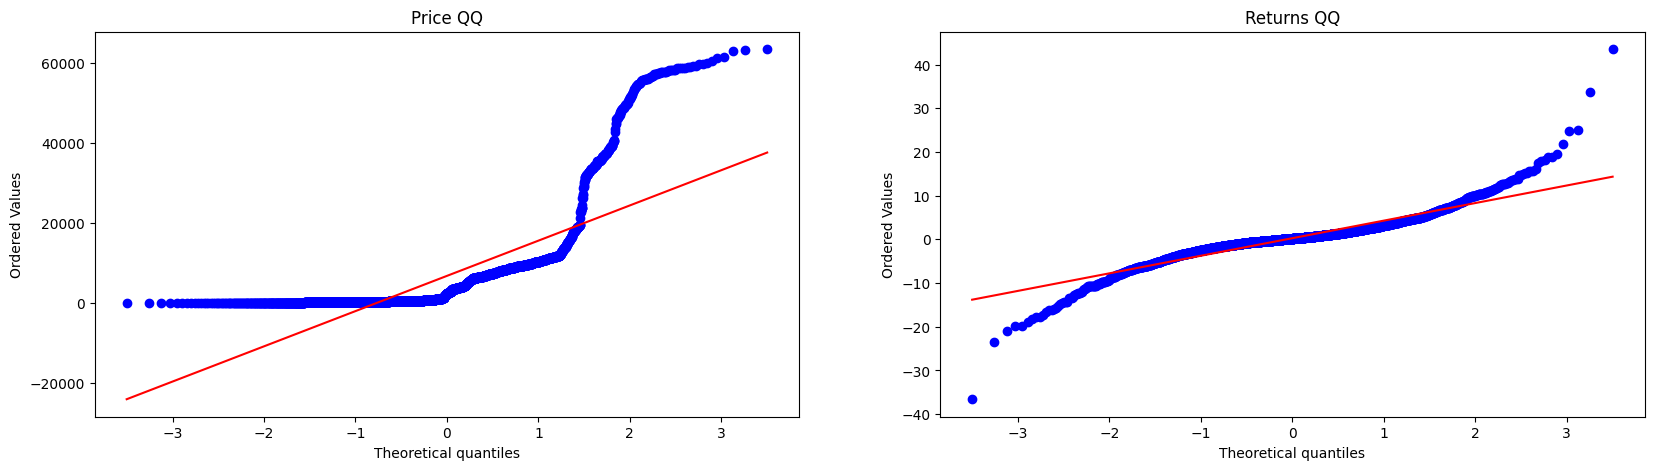

In [19]:
fig_qq, axes_qq = plt.subplots(1, 2, figsize=(20,5))
scipy.stats.probplot(df_train.price,plot=axes_qq[0])
scipy.stats.probplot(df_train.returns,plot=axes_qq[1])
axes_qq[0].set_title("Price QQ")
axes_qq[1].set_title("Returns QQ")
fig_qq.show()

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">B- Autocorrelation and partial Autocorrelation</center>

/tmp/ipykernel_2240259/2823290213.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_ret_acf.show()


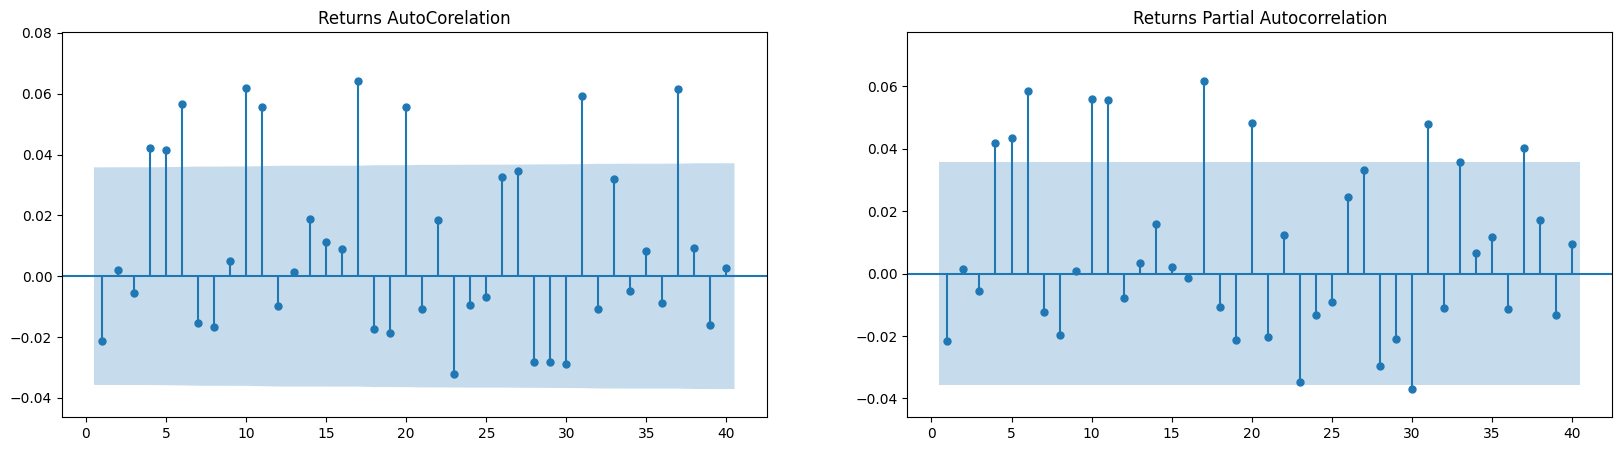

In [22]:
fig_ret_acf, axes_ret_acf = plt.subplots(1, 2, sharex=True,figsize=(20,5))

plot_acf(df_train.returns,lags=40,zero=False,ax=axes_ret_acf[0],auto_ylims=True)
plot_pacf(df_train.returns,lags=40,zero=False,ax=axes_ret_acf[1],method='ols',auto_ylims=True)
axes_ret_acf[0].set_title("Returns AutoCorelation")
axes_ret_acf[1].set_title("Returns Partial Autocorrelation")
fig_ret_acf.show()

/tmp/ipykernel_2240259/635664384.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_ret_acf.show()


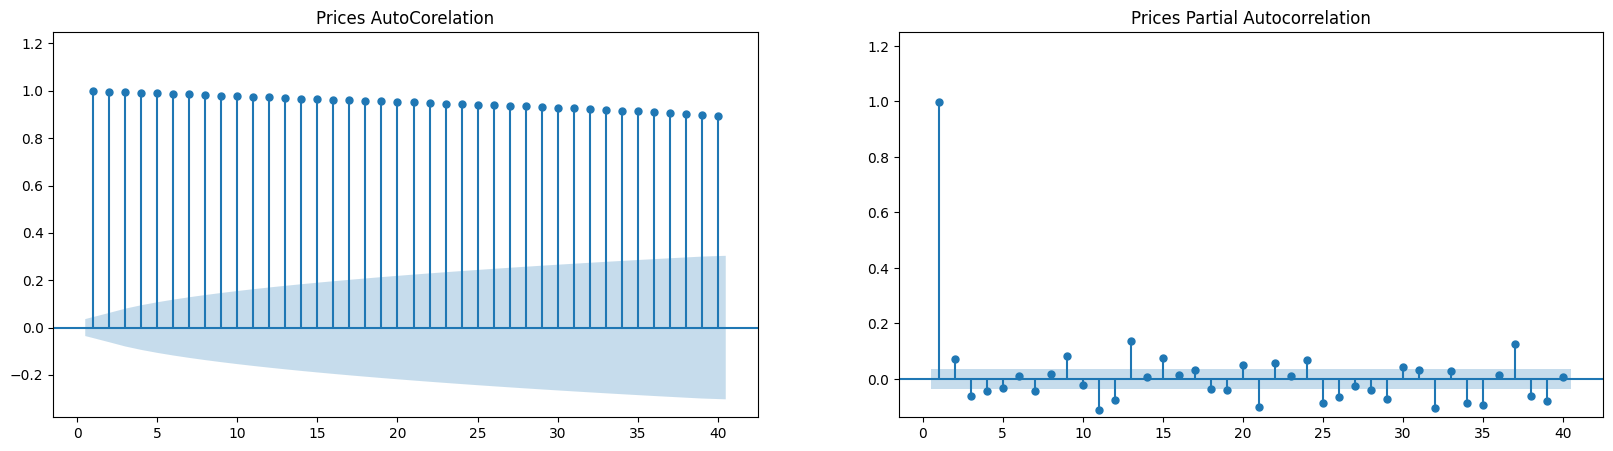

In [23]:
fig_ret_acf, axes_ret_acf = plt.subplots(1, 2, sharex=True,figsize=(20,5))

plot_acf(df_train.price,lags=40,zero=False,ax=axes_ret_acf[0],auto_ylims=True)
plot_pacf(df_train.price,lags=40,zero=False,ax=axes_ret_acf[1],method='ols',auto_ylims=True)
axes_ret_acf[0].set_title("Prices AutoCorelation")
axes_ret_acf[1].set_title("Prices Partial Autocorrelation")
fig_ret_acf.show()

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">C- Histogram</center>

/tmp/ipykernel_2240259/2195476236.py:7: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig_ret_acf.show()


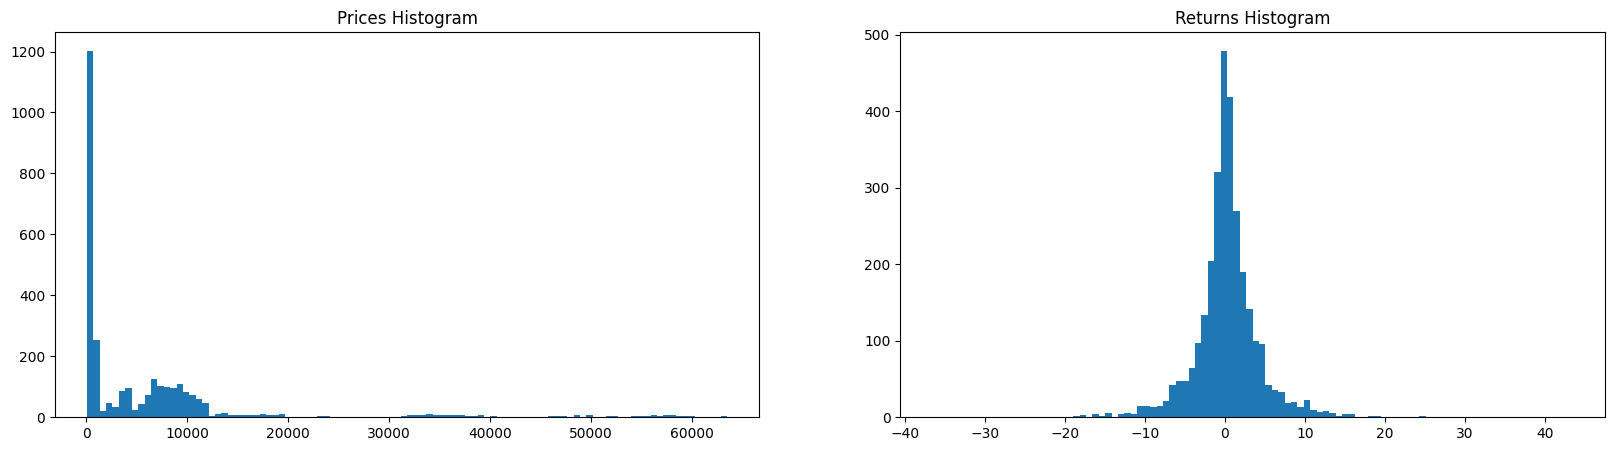

In [26]:
fig_hist, axes_hist = plt.subplots(1, 2, figsize=(20,5))

axes_hist[0].hist(df_train.price,bins=100)
axes_hist[1].hist(df_train.returns,bins=100)
axes_hist[0].set_title("Prices Histogram")
axes_hist[1].set_title("Returns Histogram")
fig_ret_acf.show()

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">D- Naive additive seasonal decompstion</center>

In [32]:
sea_decomp_df = df_train.copy(deep=True)
sea_decomp_df.index=sea_decomp_df.index.to_timestamp()

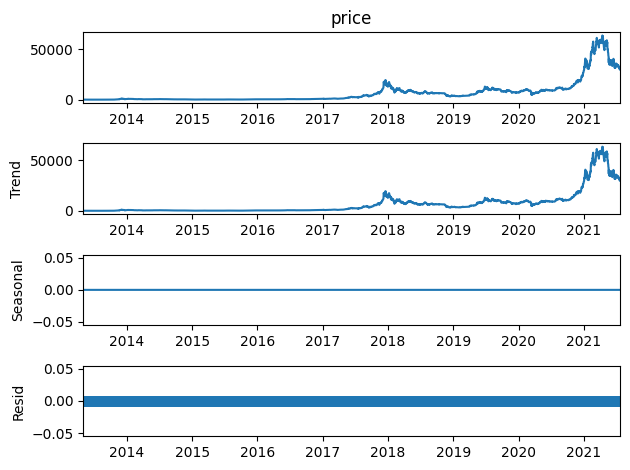

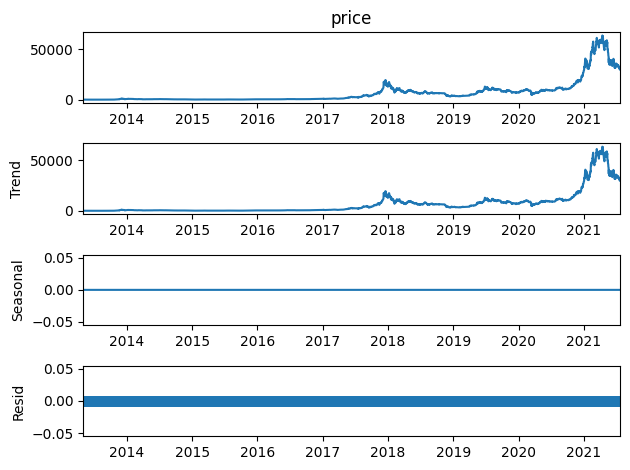

In [35]:
s_dec_add = seasonal_decompose(sea_decomp_df.price, period=1)
s_dec_add.plot()

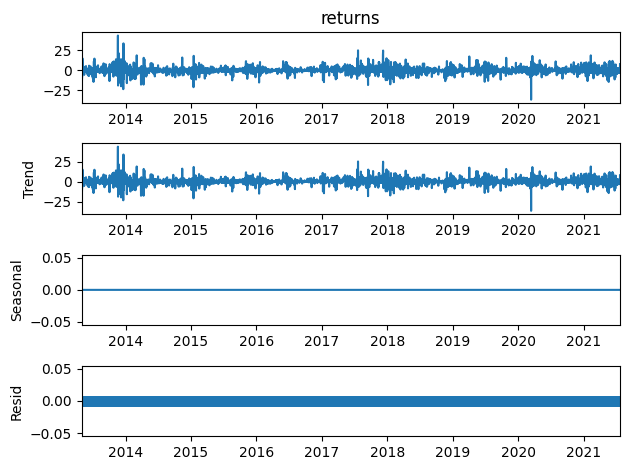

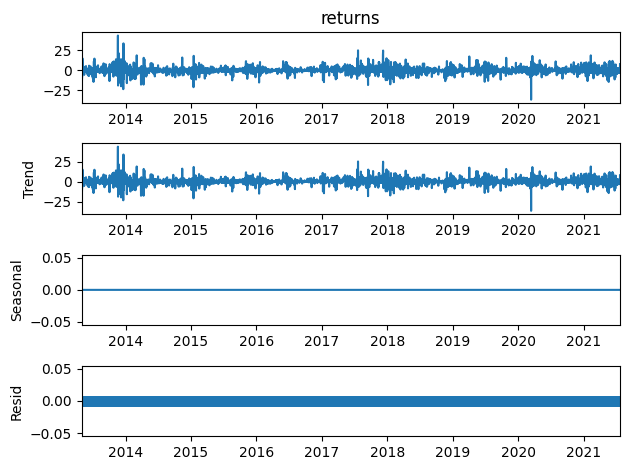

In [36]:
s_dec_add = seasonal_decompose(sea_decomp_df.returns, period=1)
s_dec_add.plot()

# <center style="background-color:#23967F;color: white; vertical-align: middle; padding:10px 5px;\">4-ARIMA Family Models</center>

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">a- AR(AutoRegressive)</center>

In [52]:
ar_model_sel_temp = ar_select_order(df_train.returns,ic ='aic', maxlag=18)
ar_model_sel_temp.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [55]:
ar_model_sel = ar_select_order(df_train.returns,ic ='aic',glob=True, maxlag=len(ar_model_sel_temp.ar_lags))
ar_model_sel.ar_lags


[1, 4, 5, 6, 10, 11, 17]

In [56]:
AR_model = AutoReg(df_train.returns, lags = ar_model_sel.ar_lags).fit()
AR_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                returns   No. Observations:                 3000
Model:             Restr. AutoReg(17)   Log Likelihood               -8521.599
Method:               Conditional MLE   S.D. of innovations              4.211
Date:                Sat, 22 Oct 2022   AIC                          17061.198
Time:                        23:19:36   BIC                          17115.204
Sample:                    05-17-2013   HQIC                         17080.629
                         - 07-22-2021                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2040      0.078      2.611      0.009       0.051       0.357
returns.L1     -0.0320      0.018     -1.755      0.079      -0.068       0.004
returns.L4      0.0423      0.018      2.328      0.020       0.007       0.078
returns.L5      0.0377      0.018      2.070      0.038       0.002       0.073
returns.L6      0.0498      0.018      2.729      0.006       0.014       0.085
returns.L10     0.0607      0.018      3.332      0.001       0.025       0.096
returns.L11     0.0509      0.018      2.785      0.005       0.015       0.087
returns.L17     0.0603      0.018      3.329      0.001       0.025       0.096
                                    Roots                                     
==============================================================================
                   Real          Imaginary           Modulus         Frequency
------------------------------------------------------------------------------
AR.1            -1.1508           -0.2049j            1.1689           -0.4720
AR.2            -1.1508           +0.2049j            1.1689            0.4720
AR.3            -1.0065           -0.6341j            1.1896           -0.4105
AR.4            -1.0065           +0.6341j            1.1896            0.4105
AR.5            -0.7254           -0.9314j            1.1806           -0.3553
AR.6            -0.7254           +0.9314j            1.1806            0.3553
AR.7            -0.3108           -1.1170j            1.1595           -0.2932
AR.8            -0.3108           +1.1170j            1.1595            0.2932
AR.9             0.1243           -1.2078j            1.2142           -0.2337
AR.10            0.1243           +1.2078j            1.2142            0.2337
AR.11            0.4795           -1.0428j            1.1477           -0.1814
AR.12            0.4795           +1.0428j            1.1477            0.1814
AR.13            0.8961           -0.7797j            1.1878           -0.1140
AR.14            0.8961           +0.7797j            1.1878            0.1140
AR.15            1.1223           -0.0000j            1.1223           -0.0000
AR.16            1.1325           -0.4552j            1.2205           -0.0608
AR.17            1.1325           +0.4552j            1.2205            0.0608
------------------------------------------------------------------------------
"""

In [57]:
ar_reisuals=AR_model.resid
ar_reisuals.mean(),ar_reisuals.std()

(9.617218557262503e-17, 4.212052905845461)

In [58]:
adfuller(ar_reisuals)

(-54.44543987627778,
 0.0,
 0,
 2982,
 {'1%': -3.4325448149029985,
  '5%': -2.8625097264772665,
  '10%': -2.5672862112626573},
 16888.014625593347)

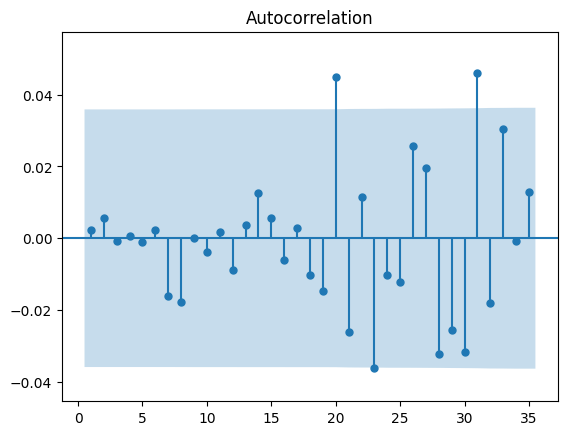

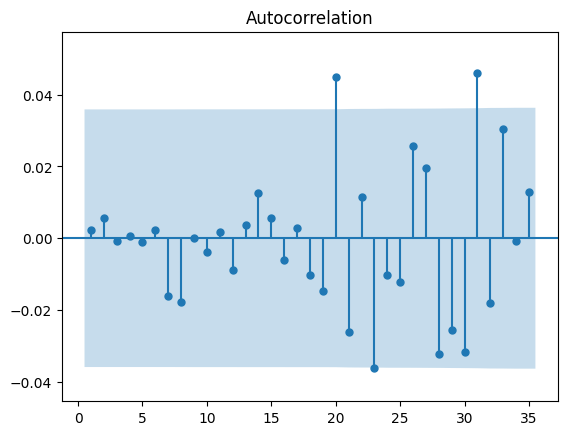

In [59]:
plot_acf(ar_reisuals,zero=False,auto_ylims=True)

In [61]:
px.line(x=ar_reisuals.index.to_timestamp(),y=ar_reisuals.T)

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">B- MA(Moving Average)</center>

In [91]:
print("| {} |      {}     |      {}      |       {}     |".format("Order", "LL", "AIC", "BIC"))

for i in range(25):
    mod = sm.tsa.arima.ARIMA(df_train.returns, order=(0, 0, i)).fit()
    print("|  {:>2}   | {:5.5f} |   {:5.5f} |   {:5.5f} |".format(i, mod.llf,mod.aic ,mod.bic))

| Order |      LL     |      AIC      |       BIC     |
|   0   | -8610.19260 |   17224.38519 |   17236.39793 |
|   1   | -8609.50116 |   17225.00231 |   17243.02142 |
|   2   | -8609.49684 |   17226.99368 |   17251.01915 |
|   3   | -8609.47702 |   17228.95404 |   17258.98587 |
|   4   | -8606.43769 |   17224.87537 |   17260.91358 |
|   5   | -8603.88532 |   17221.77064 |   17263.81521 |
|   6   | -8600.43513 |   17216.87026 |   17264.92120 |
|   7   | -8599.89087 |   17217.78174 |   17271.83905 |
|   8   | -8599.42277 |   17218.84554 |   17278.90922 |
|   9   | -8599.31544 |   17220.63088 |   17286.70092 |
|  10   | -8593.44677 |   17210.89354 |   17282.96995 |
|  11   | -8589.87556 |   17205.75113 |   17283.83391 |
|  12   | -8589.68238 |   17207.36476 |   17291.45391 |
|  13   | -8589.65753 |   17209.31506 |   17299.41058 |
|  14   | -8589.14318 |   17210.28636 |   17306.38824 |
|  15   | -8589.01171 |   17212.02342 |   17314.13167 |
|  16   | -8589.01124 |   17214.02248 |   17322.

In [92]:
MA_model = sm.tsa.arima.ARIMA(df_train.returns, order=(0, 0, 17)).fit()#17 lags have the lowest AIC
MA_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 3000
Model:                ARIMA(0, 0, 17)   Log Likelihood               -8581.991
Date:                Sat, 22 Oct 2022   AIC                          17201.982
Time:                        23:32:15   BIC                          17316.103
Sample:                    04-30-2013   HQIC                         17243.031
                         - 07-22-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2724      0.102      2.667      0.008       0.072       0.473
ma.L1         -0.0257      0.011     -2.242      0.025      -0.048      -0.003
ma.L2          0.0023      0.014      0.162      0.871      -0.025       0.030
ma.L3         -0.0092      0.012     -0.764      0.445      -0.033       0.014
ma.L4          0.0439      0.014      3.064      0.002       0.016       0.072
ma.L5          0.0358      0.014      2.498      0.013       0.008       0.064
ma.L6          0.0546      0.015      3.558      0.000       0.025       0.085
ma.L7         -0.0210      0.013     -1.558      0.119      -0.047       0.005
ma.L8         -0.0132      0.015     -0.867      0.386      -0.043       0.017
ma.L9         -0.0017      0.016     -0.108      0.914      -0.033       0.029
ma.L10         0.0606      0.015      3.931      0.000       0.030       0.091
ma.L11         0.0565      0.014      3.952      0.000       0.028       0.084
ma.L12        -0.0050      0.015     -0.330      0.742      -0.035       0.025
ma.L13         0.0088      0.014      0.642      0.521      -0.018       0.036
ma.L14         0.0123      0.015      0.835      0.404      -0.017       0.041
ma.L15         0.0134      0.015      0.900      0.368      -0.016       0.043
ma.L16        -0.0048      0.015     -0.314      0.753      -0.034       0.025
ma.L17         0.0711      0.014      5.055      0.000       0.044       0.099
sigma2        17.8750      0.213     83.996      0.000      17.458      18.292
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11363.78
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.71   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [93]:
ma_reisuals=MA_model.resid
ma_reisuals.mean(),ma_reisuals.std()

(0.0008643436444574138, 4.229064679536471)

In [94]:
adfuller(ma_reisuals)

(-54.787469494905636,
 0.0,
 0,
 2999,
 {'1%': -3.43253236279788,
  '5%': -2.86250422682754,
  '10%': -2.5672832833096195},
 16978.1651216072)

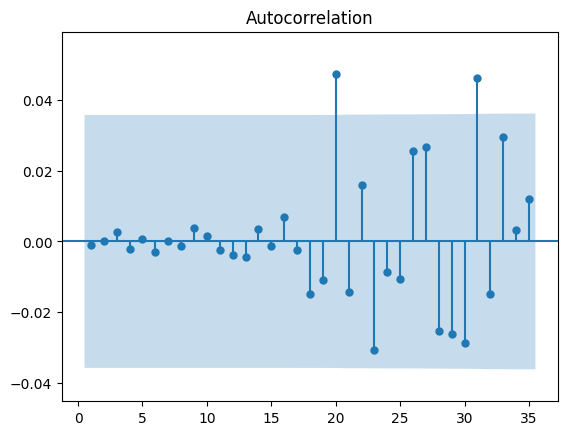

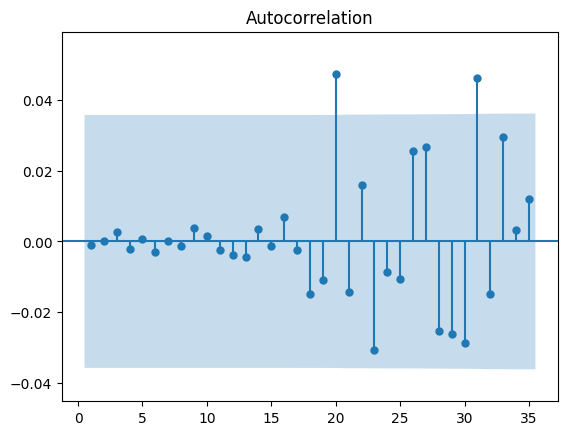

In [95]:
plot_acf(ma_reisuals,zero=False,auto_ylims=True)

In [96]:
px.line(x=ma_reisuals.index.to_timestamp(),y=ma_reisuals.T)

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">C- ARMA(AutoRegressive Moving Average)</center>

In [ ]:
arma_model_sel = sm.tsa.arma_order_select_ic(
    df_train.returns, ic=["aic", "bic"],
    max_ar = 20,
    max_ma=20,
    trend=None,
    )

arma_model_sel.aic_min_order,arma_model_sel.bic_min_order

In [103]:
arma_model = sm.tsa.arima.ARIMA(df_train.returns, order=(13, 0, 17)).fit()

arma_model.summary()

/home/ub/anaconda3/envs/crypto-for/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                returns   No. Observations:                 3000
Model:               ARIMA(13, 0, 17)   Log Likelihood               -8562.094
Date:                Sat, 22 Oct 2022   AIC                          17188.187
Time:                        23:39:57   BIC                          17380.391
Sample:                    04-30-2013   HQIC                         17257.323
                         - 07-22-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2696      0.096      2.800      0.005       0.081       0.458
ar.L1         -0.1337      0.353     -0.378      0.705      -0.826       0.559
ar.L2          0.0489      0.237      0.206      0.837      -0.416       0.514
ar.L3          0.0793      0.154      0.515      0.607      -0.223       0.381
ar.L4         -0.1013      0.181     -0.561      0.575      -0.455       0.253
ar.L5          0.0008      0.144      0.006      0.995      -0.281       0.282
ar.L6          0.3949      0.147      2.688      0.007       0.107       0.683
ar.L7          0.4282      0.132      3.254      0.001       0.170       0.686
ar.L8         -0.1337      0.120     -1.118      0.264      -0.368       0.101
ar.L9          0.1852      0.116      1.590      0.112      -0.043       0.413
ar.L10         0.0982      0.164      0.598      0.550      -0.224       0.420
ar.L11         0.3582      0.102      3.513      0.000       0.158       0.558
ar.L12        -0.3883      0.204     -1.901      0.057      -0.789       0.012
ar.L13        -0.5270      0.285     -1.852      0.064      -1.085       0.031
ma.L1          0.1087      0.353      0.308      0.758      -0.584       0.801
ma.L2         -0.0466      0.245     -0.190      0.849      -0.527       0.434
ma.L3         -0.0749      0.159     -0.471      0.638      -0.387       0.237
ma.L4          0.1482      0.183      0.811      0.417      -0.210       0.506
ma.L5          0.0329      0.155      0.212      0.832      -0.271       0.337
ma.L6         -0.3513      0.150     -2.348      0.019      -0.645      -0.058
ma.L7         -0.4416      0.119     -3.709      0.000      -0.675      -0.208
ma.L8          0.1424      0.137      1.038      0.299      -0.126       0.411
ma.L9         -0.1693      0.134     -1.262      0.207      -0.432       0.094
ma.L10        -0.0544      0.177     -0.307      0.759      -0.402       0.293
ma.L11        -0.3385      0.120     -2.814      0.005      -0.574      -0.103
ma.L12         0.3644      0.213      1.708      0.088      -0.054       0.782
ma.L13         0.5099      0.278      1.832      0.067      -0.036       1.056
ma.L14        -0.0063      0.023     -0.267      0.790      -0.052       0.040
ma.L15        -0.0307      0.022     -1.367      0.172      -0.075       0.013
ma.L16        -0.0168      0.025     -0.676      0.499      -0.066       0.032
ma.L17         0.0421      0.021      2.039      0.041       0.002       0.083
sigma2        17.6424      0.232     75.924      0.000      17.187      18.098
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             10821.09
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.29
========================================================

In [104]:
arma_reisuals=arma_model.resid
arma_reisuals.mean(),arma_reisuals.std()

(0.0033544470085418144, 4.201325477109077)

In [105]:
adfuller(arma_reisuals)

(-54.78368343393401,
 0.0,
 0,
 2999,
 {'1%': -3.43253236279788,
  '5%': -2.86250422682754,
  '10%': -2.5672832833096195},
 16938.31887894971)

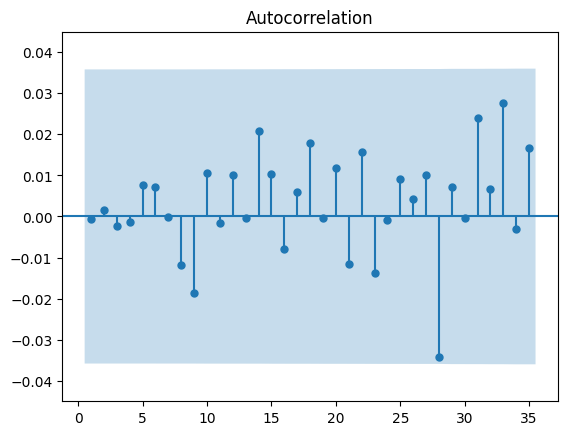

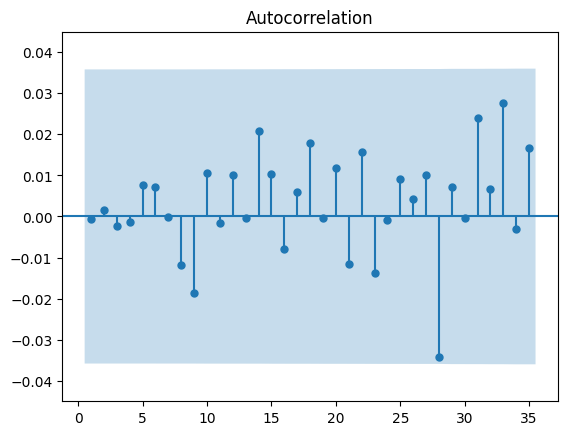

In [106]:
plot_acf(arma_reisuals,zero=False,auto_ylims=True)

In [107]:
px.line(x=arma_reisuals.index.to_timestamp(),y=arma_reisuals.T)

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">D- ARIMA(AutoRegressive Integrated Moving Average)</center>

In [109]:
num_integration=1
adfuller(df_train.price.diff(num_integration)[num_integration:])#---> one integration is enough to make the price stationary

(-9.032362235195933,
 5.401930264612278e-15,
 29,
 2969,
 {'1%': -3.432554433400684,
  '5%': -2.862513974608172,
  '10%': -2.5672884729234764},
 46080.985733671834)

From PACF p possible values 12,30,45<br>
From ACF  q possible values 12,30,45

In [115]:
arima_models_res=[]
for p,q in  itertools.product([12,30,45], [12,30,45]):
    model = sm.tsa.arima.ARIMA(df_train.price, order=(p, 1, q)).fit()
    arima_models_res.append((p,q,model.llf,model.aic,model.bic))
#arima.fit(method_kwargs={"warn_convergence": False})


/home/ub/anaconda3/envs/crypto-for/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/home/ub/anaconda3/envs/crypto-for/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

/home/ub/anaconda3/envs/crypto-for/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ub/anaconda3/envs/crypto-for/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ub/anaconda3/envs/crypto-for/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/home/ub/anaconda3/en

In [116]:
arima_models_res.sort(key=lambda x: x[3]) 
print("| {} |      {}     |      {}      |       {}     |".format("Order", "LL", "AIC", "BIC"))

for mod_res in arima_models_res:
    print("|{:>2}|{:>2}| {:5.5f} |   {:5.5f} |   {:5.5f} |".format(mod_res[0],mod_res[1], mod_res[2],mod_res[3],mod_res[4]))

| Order |      LL     |      AIC      |       BIC     |
|45|45| -23008.17986 |   46198.35972 |   46744.90883 |
|30|45| -23029.38592 |   46210.77184 |   46667.23044 |
|45|30| -23047.53137 |   46247.06275 |   46703.52134 |
|12|45| -23084.97435 |   46285.94870 |   46634.29868 |
|30|30| -23092.48537 |   46306.97073 |   46673.33882 |
|45|12| -23108.99504 |   46333.99008 |   46682.34006 |
|30|12| -23141.44958 |   46368.89916 |   46627.15863 |
|12|30| -23142.50406 |   46371.00812 |   46629.26759 |
|12|12| -23203.57077 |   46457.14155 |   46607.29240 |


In [118]:
arima_model = sm.tsa.arima.ARIMA(df_train.price, order=(45, 1, 45)).fit(method_kwargs={"warn_convergence": False})
# even though most coefficents are below the signifcance level but the model with p=q=45 have the highest log-likelihood and lowest AIC
# thats why i opted for it
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                 3000
Model:               ARIMA(45, 1, 45)   Log Likelihood              -23008.180
Date:                Sun, 23 Oct 2022   AIC                          46198.360
Time:                        00:23:21   BIC                          46744.909
Sample:                    04-30-2013   HQIC                         46394.955
                         - 07-22-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0497      0.948     -0.052      0.958      -1.909       1.809
ar.L2          0.0231      0.548      0.042      0.966      -1.051       1.097
ar.L3         -0.0545      0.295     -0.185      0.853      -0.633       0.524
ar.L4         -0.0814      0.237     -0.344      0.731      -0.545       0.383
ar.L5          0.0321      0.098      0.327      0.743      -0.160       0.224
ar.L6          0.0390      0.090      0.432      0.666      -0.138       0.216
ar.L7         -0.0804      0.107     -0.754      0.451      -0.289       0.129
ar.L8          0.0339      0.111      0.306      0.760      -0.183       0.251
ar.L9         -0.0133      0.107     -0.125      0.900      -0.222       0.196
ar.L10         0.1584      0.076      2.081      0.037       0.009       0.308
ar.L11         0.0110      0.133      0.083      0.934      -0.249       0.271
ar.L12        -0.1078      0.115     -0.937      0.349      -0.333       0.118
ar.L13        -0.0338      0.130     -0.259      0.795      -0.289       0.221
ar.L14        -0.1150      0.074     -1.547      0.122      -0.261       0.031
ar.L15         0.0975      0.126      0.772      0.440      -0.150       0.345
ar.L16         0.0249      0.112      0.221      0.825      -0.195       0.245
ar.L17         0.0139      0.129      0.108      0.914      -0.239       0.267
ar.L18        -0.0858      0.084     -1.021      0.307      -0.250       0.079
ar.L19         0.1135      0.101      1.120      0.263      -0.085       0.312
ar.L20         0.0016      0.081      0.020      0.984      -0.157       0.161
ar.L21         0.0314      0.082      0.385      0.700      -0.128       0.191
ar.L22         0.1523      0.050      3.042      0.002       0.054       0.250
ar.L23        -0.0710      0.189     -0.375      0.707      -0.442       0.300
ar.L24         0.0640      0.096      0.671      0.502      -0.123       0.251
ar.L25         0.0347      0.096      0.361      0.718      -0.154       0.223
ar.L26         0.0777      0.125      0.622      0.534      -0.167       0.323
ar.L27         0.0557      0.064      0.863      0.388      -0.071       0.182
ar.L28         0.1987      0.095      2.092      0.036       0.013       0.385
ar.L29        -0.2144      0.184     -1.165      0.244      -0.575       0.146
ar.L30         0.0336      0.180      0.187      0.852      -0.318       0.385
ar.L31         0.0577      0.149      0.387      0.699      -0.234       0.350
ar.L32        -0.0164      0.151     -0.109      0.913      -0.312       0.279
ar.L33         0.1376      0.083      1.653      0.098      -0.026       0.301
ar.L34         0.1224      0.180      0.679      0.497      -0.231       0.475
ar.L35         0.0340      0.188      0.181      0.856      -0.334       0.402
ar.L36        -0.0479      0.069     -0.696      0.486      -0.183       0.087
ar.L37         0.0337      0.070      0.480      0.632      -0.104       0.171
ar.L38         0.1044      0.051      2.033      0.042       0.004       0.205
ar

In [123]:
arima_reisuals=arima_model.resid
arima_reisuals.mean(),arima_reisuals.std()

(8.229751643551474, 517.842903073493)

In [124]:
adfuller(arima_reisuals)

(-54.53869944356233,
 0.0,
 0,
 2999,
 {'1%': -3.43253236279788,
  '5%': -2.86250422682754,
  '10%': -2.5672832833096195},
 45584.31785673276)

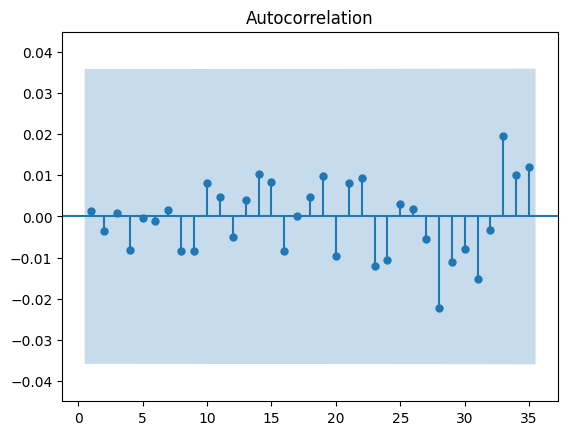

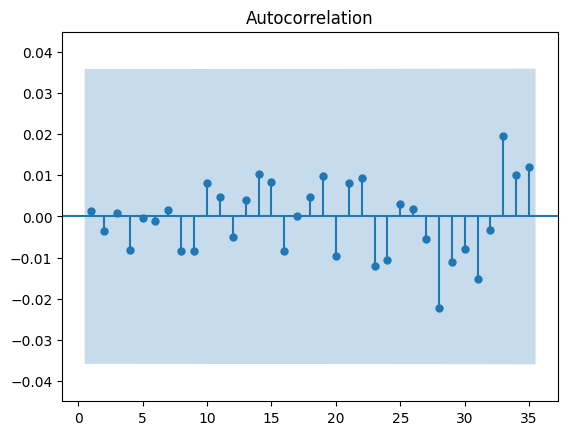

In [125]:
plot_acf(arima_reisuals,zero=False,auto_ylims=True)

In [126]:
px.line(x=arima_reisuals.index.to_timestamp(),y=arima_reisuals.T)

the residuals are considered white noise for every part except for crypto bubbles and bubble correction
<br>which is expected with the high volatility of crypto

## <center style="background-color:#F06543;color: white; vertical-align: middle; padding:5px px;\">Arima family Predictions</center>

In [132]:
df_test

,price,returns
date,,
2021-07-23,32305.958852,0.519888
2021-07-24,33593.729412,3.986170
2021-07-25,34290.291385,2.073488
2021-07-26,35384.029885,3.189645
2021-07-27,37276.036030,5.347062
...,...,...
2022-10-09,19417.479411,-0.659200
2022-10-10,19446.416225,0.149025
2022-10-11,19138.999877,-1.580838


In [129]:
start_date = "2021-07-23"
end_date   = "2022-10-13" 

In [137]:
df_test["ar_returns"]   = AR_model.predict(start=start_date,end=end_date)
df_test["ma_returns"]   = MA_model.predict(start=start_date,end=end_date)
df_test["arma_returns"] = arma_model.predict(start=start_date,end=end_date)
df_test["arima_prices"] = arima_model.predict(start=start_date,end=end_date)

/tmp/ipykernel_2240259/2358139849.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2240259/2358139849.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_2240259/2358139849.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [140]:
df_test

,price,returns,ar_returns,ma_returns,arma_returns,arima_prices
date,,,,,,
2021-07-23,32305.958852,0.519888,0.370345,0.389840,0.336936,34567.881369
2021-07-24,33593.729412,3.986170,-0.155336,-0.183820,-0.368774,34992.288161
2021-07-25,34290.291385,2.073488,-0.221103,-0.324369,1.018861,35528.062230
2021-07-26,35384.029885,3.189645,0.560998,0.504604,0.770092,35812.521416
2021-07-27,37276.036030,5.347062,0.425713,0.490425,0.196535,36014.805595
...,...,...,...,...,...,...
2022-10-09,19417.479411,-0.659200,0.279371,0.272375,0.270853,36820.997559
2022-10-10,19446.416225,0.149025,0.279371,0.272375,0.270550,36808.311144
2022-10-11,19138.999877,-1.580838,0.279371,0.272375,0.268757,36908.925508


In [144]:
px.line(df_test,x=df_test.index.to_timestamp(),y=["returns","ar_returns","ma_returns","arma_returns"])

In [146]:
px.line(df_test,x=df_test.index.to_timestamp(),y=["price","arima_prices"])

 ### oh that's a bad forecast maybe prophet will do better
 ### I believe the reason/s are one/some of the following :
 ### 1 - the model's selection failed
 ### 2 - arima models are not sufficient to predict such time series
 ### 3 - the data split is not good enough because I selected the split before a big bubble
 ### 4 - crypto is highly volatile making it un-forcastable with high accuracy